In [2]:
import sys
sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
#from bearinmind_pipeline import data_preprocessing, model_construction, results_blend
import gc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)


In [3]:
# !kaggle competitions download -c ieee-fraud-detection
# !unzip \*.zip
# !rm *.zip
# !chmod 600 *.csv

In [4]:
gc.collect()

99

In [5]:
df_train_id = pd.read_csv('train_identity.csv')
df_test_id = pd.read_csv('test_identity.csv')
df_train_txn = pd.read_csv('train_transaction.csv')
df_test_txn = pd.read_csv('test_transaction.csv')

In [6]:
df_train_txn = df_train_txn.merge(df_train_id, how = 'left', on  = 'TransactionID')
df_test_txn = df_test_txn.merge(df_test_id, how = 'left', on  = 'TransactionID')

In [7]:
# Calculate Seconds from the most recent transaction
df_train_txn['Seconds_Most_Recent'] = df_train_txn['TransactionDT'] - df_train_txn['TransactionDT'].min()
df_train_txn['Minute_Most_Recent'] = round( df_train_txn['Seconds_Most_Recent'] / 60, 0)
df_train_txn['Hour_Most_Recent'] = round( df_train_txn['Minute_Most_Recent'] / 60, 0)
df_train_txn['Day_Most_Recent'] = round( df_train_txn['Hour_Most_Recent'] / 24, 0)
df_train_txn['Week_Most_Recent'] = round( df_train_txn['Day_Most_Recent'] / 7, 0)
df_train_txn['Months_Most_Recent'] = round( df_train_txn['Day_Most_Recent'] / 30, 0)

In [8]:
df_test_txn['Seconds_Most_Recent'] = df_test_txn['TransactionDT'] - df_test_txn['TransactionDT'].min()
df_test_txn['Minute_Most_Recent'] = round(df_test_txn['Seconds_Most_Recent'] / 60, 0)
df_test_txn['Hour_Most_Recent'] = round(df_test_txn['Minute_Most_Recent'] / 60, 0)
df_test_txn['Day_Most_Recent'] = round(df_test_txn['Hour_Most_Recent'] / 24, 0)
df_test_txn['Week_Most_Recent'] = round(df_test_txn['Day_Most_Recent'] / 7, 0)
df_test_txn['Months_Most_Recent'] = round(df_test_txn['Day_Most_Recent'] / 30, 0)

In [9]:
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', 'Week_Most_Recent')
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', 'Week_Most_Recent')
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', 'Day_Most_Recent')
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', 'Day_Most_Recent')
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', 'Months_Most_Recent')
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', 'Months_Most_Recent')

In [10]:
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', ['Week_Most_Recent', 'card1'])
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', ['Week_Most_Recent', 'card1'])
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', ['Day_Most_Recent', 'card1'])
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', ['Day_Most_Recent', 'card1'])
df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', ['Months_Most_Recent', 'card1'])
df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', ['Months_Most_Recent', 'card1'])

In [11]:
df_train_txn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Seconds_Most_Recent,Minute_Most_Recent,Hour_Most_Recent,Day_Most_Recent,Week_Most_Recent,Months_Most_Recent,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_Week_Most_Recent_card1_std,TransactionAmt_by_Week_Most_Recent_card1_mean,TransactionAmt_by_Week_Most_Recent_card1_median,TransactionAmt_by_Week_Most_Recent_card1_max,TransactionAmt_by_Week_Most_Recent_card1_min,TransactionAmt_by_Day_Most_Recent_card1_std,TransactionAmt_by_Day_Most_Recent_card1_mean,TransactionAmt_by_Day_Most_Recent_card1_median,TransactionAmt_by_Day_Most_Recent_card1_max,TransactionAmt_by_Day_Most_Recent_card1_min,TransactionAmt_by_Months_Most_Recent_card1_std,TransactionAmt_by_Months_Most_Recent_card1_mean,TransactionAmt_by_Months_Most_Recent_card1_median,TransactionAmt_by_Months_Most_Recent_card1_max,TransactionAmt_by_Months_Most_Recent_card1_min
0,2987000,0,86400,68.500,W,13926,nan,150.000,discover,142.000,credit,315.000,87.000,19.000,nan,NaN,NaN,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,nan,13.000,nan,nan,nan,nan,nan,nan,13.000,13.000,nan,nan,nan,0

In [11]:
'_'.join(['Week_Most_Recent', 'card1'])

'Week_Most_Recent_card1'

In [12]:
#week_mean_train[df_train_txn['Week_Most_Recent']]
def find_time_before(dct, period, x):
        try:
            y = dct[x+period]
        except:
            y = np.nan
        return(y)

def prep_weeks_before(df, n_before, date_agg = "Week"):
    _mean = dict(df.groupby(f'{date_agg}_Most_Recent')['TransactionAmt'].mean())
    _min = dict(df.groupby(f'{date_agg}_Most_Recent')['TransactionAmt'].min())
    _max = dict(df.groupby(f'{date_agg}_Most_Recent')['TransactionAmt'].max())
    _std = dict(df.groupby(f'{date_agg}_Most_Recent')['TransactionAmt'].std())
    
    for n in n_before:
        df[f'{n}_{date_agg}_Before_Mean'] = df['TransactionAmt']/df[f'{date_agg}_Most_Recent'].apply(lambda x: find_time_before(_mean, n, x))
        df[f'{n}_{date_agg}_Before_Min'] = df['TransactionAmt']/df[f'{date_agg}_Most_Recent'].apply(lambda x: find_time_before(_min, n, x))
        df[f'{n}_{date_agg}_Before_Max'] = df['TransactionAmt']/df[f'{date_agg}_Most_Recent'].apply(lambda x: find_time_before(_max, n, x))
        df[f'{n}_{date_agg}_Before_Std'] = df['TransactionAmt']/df[f'{date_agg}_Most_Recent'].apply(lambda x: find_time_before(_std, n, x))
        
        print(f'{n} {date_agg} is finished ...')
    
    return df

In [13]:
#df_train_txn = prep_weeks_before(df_train_txn, [1,2,3,4], "Week")
#df_train_txn = prep_weeks_before(df_train_txn, [1,2,3,4,5,6,7,8,9,10], "Hour")
#df_train_txn = prep_weeks_before(df_train_txn, [1,2], "Months")
#df_train_txn = prep_weeks_before(df_train_txn, [1,2,3,4,5,6,7], "Day")

In [14]:
#df_test_txn = prep_weeks_before(df_test_txn, [1,2,3,4], "Week")
#df_test_txn = prep_weeks_before(df_test_txn, [1,2,3,4,5,6,7,8,9,10], "Hour")
#df_test_txn = prep_weeks_before(df_test_txn, [1,2], "Months")
#df_test_txn= prep_weeks_before(df_test_txn, [1,2,3,4,5,6,7], "Day")

In [15]:
df_train_txn['DeviceInfo'] = np.where(~df_train_txn.DeviceInfo.isin(['Windows', 'iOS Device', 'MacOS']), 'Android', df_train_txn.DeviceInfo)

In [16]:
df_test_txn['DeviceInfo'] = np.where(~df_test_txn.DeviceInfo.isin(['Windows', 'iOS Device', 'MacOS']), 'Android', df_test_txn.DeviceInfo)

In [17]:
# parse Email column
df_train_txn = dp.parse_str_col(df_train_txn, ['R_emaildomain', 'P_emaildomain'], parse_by = '.', n_element = 0)
df_test_txn = dp.parse_str_col(df_test_txn, ['R_emaildomain', 'P_emaildomain'], parse_by = '.', n_element = 0)

In [18]:
#parse id 30 & 31 column
df_train_txn = dp.parse_str_col(df_train_txn, ['id_30', 'id_31'], parse_by = ' ', n_element = 0)
df_test_txn = dp.parse_str_col(df_test_txn, ['id_30', 'id_31'], parse_by = ' ', n_element = 0)

In [19]:
df_train_txn = dp.parse_str_col(df_train_txn, ['id_31'], parse_by = '/', n_element = 0)
df_test_txn = dp.parse_str_col(df_test_txn, ['id_31'], parse_by = '/', n_element = 0)

In [20]:
df_train_txn['id_31'] = df_train_txn['id_31'].str.lower()
df_test_txn['id_31'] = df_test_txn['id_31'].str.lower()

In [21]:
df_train_txn['id_31'] = np.where(df_train_txn.id_31.isin(['mozilla']), 'firefox', df_train_txn.id_31)
df_test_txn['id_31'] = np.where(df_test_txn.id_31.isin(['mozilla']), 'firefox', df_test_txn.id_31)

In [22]:
#parse id 33 resolution
df_train_txn['horizontal_pixels'] = df_train_txn['id_33'].str.split('x').str.get(0)
df_test_txn['horizontal_pixels'] = df_test_txn['id_33'].str.split('x').str.get(0)
df_train_txn['vertical_pixels'] = df_train_txn['id_33'].str.split('x').str.get(1)
df_test_txn['vertical_pixels'] = df_test_txn['id_33'].str.split('x').str.get(1)

In [23]:
df_train_txn['horizontal_pixels'] = pd.to_numeric(df_train_txn['horizontal_pixels'])
df_test_txn['horizontal_pixels'] = pd.to_numeric(df_test_txn['horizontal_pixels'])
df_train_txn['vertical_pixels'] = pd.to_numeric(df_train_txn['vertical_pixels'])
df_test_txn['vertical_pixels'] = pd.to_numeric(df_test_txn['vertical_pixels'])

In [24]:
df_train_txn = df_train_txn.drop('id_33', axis = 1)
df_test_txn = df_test_txn.drop('id_33', axis = 1)

In [25]:
#encode_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'id_12', 'M1', 'M2', 'M3', 'M4', 'M5',  'M6', 'M7', 'M8', 'M9',       
#              'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
encode_cols = ['ProductCD', 'card1','card2','card3','card4', 'card5','card6', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'M1', 'M2', 'M3', 'M4', 'M5',  'M6', 'M7', 'M8', 'M9',       
              'id_12','id_13', 'id_14','id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20','id_21', 'id_22', 'id_23', 'id_24','id_25','id_26','id_27', 'id_28', 'id_29', 'id_30', 'id_31', 
               'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [26]:
df_train_txn[encode_cols] = df_train_txn[encode_cols].where(df_train_txn[encode_cols].notnull(), 'NaN')

In [27]:
df_test_txn[encode_cols] = df_test_txn[encode_cols].where(df_test_txn[encode_cols].notnull(), 'NaN')

In [28]:
cols = list(df_train_txn.columns.values)

In [29]:
cols.remove('isFraud')

In [30]:
df_test_txn = df_test_txn[cols]

In [31]:
#Encode categorical
data = dp.encode_categorical(df_train_txn, df_test_txn, encode_cols)
df_train_txn = data[0]
df_test_txn = data[1]

colums ProductCD is being encoded
colums card1 is being encoded
colums card2 is being encoded
colums card3 is being encoded
colums card4 is being encoded
colums card5 is being encoded
colums card6 is being encoded
colums P_emaildomain is being encoded
colums R_emaildomain is being encoded
colums DeviceType is being encoded
colums DeviceInfo is being encoded
colums M1 is being encoded
colums M2 is being encoded
colums M3 is being encoded
colums M4 is being encoded
colums M5 is being encoded
colums M6 is being encoded
colums M7 is being encoded
colums M8 is being encoded
colums M9 is being encoded
colums id_12 is being encoded
colums id_13 is being encoded
colums id_14 is being encoded
colums id_15 is being encoded
colums id_16 is being encoded
colums id_17 is being encoded
colums id_18 is being encoded
colums id_19 is being encoded
colums id_20 is being encoded
colums id_21 is being encoded
colums id_22 is being encoded
colums id_23 is being encoded
colums id_24 is being encoded
colums 

In [32]:
#df_train_txn = dp.create_stats_features(df_train_txn, 'TransactionAmt', 'card1')
#df_test_txn = dp.create_stats_features(df_test_txn, 'TransactionAmt', 'card1')

In [33]:
#Initiate ModelBuilder Class
mb = mc.modelBuilder('classification', 'LGBM')

In [34]:
data = mb.prepare_data_split(df_train =  df_train_txn, df_test = df_test_txn, target = 'isFraud', rem_cols = ['TransactionID', 'TransactionDT'], useVarImp = False, varimp_threshold = 100)

468 features have been chosen for modeling


In [35]:
# LGBM
params = {
    'boosting_type':'gbdt',
    'n_estimators':1000,
    'num_leaves':128, 
    'objective':'binary', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.2,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'auc', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':0, 
    'reg_alpha':0.0,
    'reg_lambda':0.0, 
    'silent':True, 
    'subsample':1.0
}

# XGBoost
params_xgb = {
    'n_estimators':500,
    'max_depth':9,
    'learning_rate':0.05,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'tree_method' : 'hist',
    'nthread': 42
    #'categorical_feature': encode_cols
}

In [36]:
data[0] = data[0].replace(np.nan, 0, regex=True)
data[0] = data[0].replace(np.inf, 0, regex=True)

In [37]:
data[0].head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Seconds_Most_Recent,Minute_Most_Recent,Hour_Most_Recent,Day_Most_Recent,Week_Most_Recent,Months_Most_Recent,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_W_e_e_k___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_D_a_y___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_std,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_mean,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_median,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_max,TransactionAmt_by_M_o_n_t_h_s___M_o_s_t___R_e_c_e_n_t_min,TransactionAmt_by_Week_Most_Recent_card1_std,TransactionAmt_by_Week_Most_Recent_card1_mean,TransactionAmt_by_Week_Most_Recent_card1_median,TransactionAmt_by_Week_Most_Recent_card1_max,TransactionAmt_by_Week_Most_Recent_card1_min,TransactionAmt_by_Day_Most_Recent_card1_std,TransactionAmt_by_Day_Most_Recent_card1_mean,TransactionAmt_by_Day_Most_Recent_card1_median,TransactionAmt_by_Day_Most_Recent_card1_max,TransactionAmt_by_Day_Most_Recent_card1_min,TransactionAmt_by_Months_Most_Recent_card1_std,TransactionAmt_by_Months_Most_Recent_card1_mean,TransactionAmt_by_Months_Most_Recent_card1_median,TransactionAmt_by_Months_Most_Recent_card1_max,TransactionAmt_by_Months_Most_Recent_card1_min,horizontal_pixels,vertical_pixels
0,68.500,4,12696,501,50,2,42,2,315.000,87.000,19.000,0.000,0,0,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2.000,0.000,1.000,1.000,14.000,0.000,13.000,0.000,0.000,0.000,0.000,0.000,0.000,13.000,13.000,0.000,0.000,0.000,0.000,2,2,2,2,0,2,1,1,1,1.000

Fold: 0
The valuation metric for the fold 0 is 0.9684965240758998
Fold: 1
The valuation metric for the fold 1 is 0.967135039677539
Fold: 2
The valuation metric for the fold 2 is 0.9658467118702575
Fold: 3
The valuation metric for the fold 3 is 0.964487467642807
Fold: 4
The valuation metric for the fold 4 is 0.9664724184783329
The average score accross the folds is 0.9664876323489672
Displaying variable importance ...


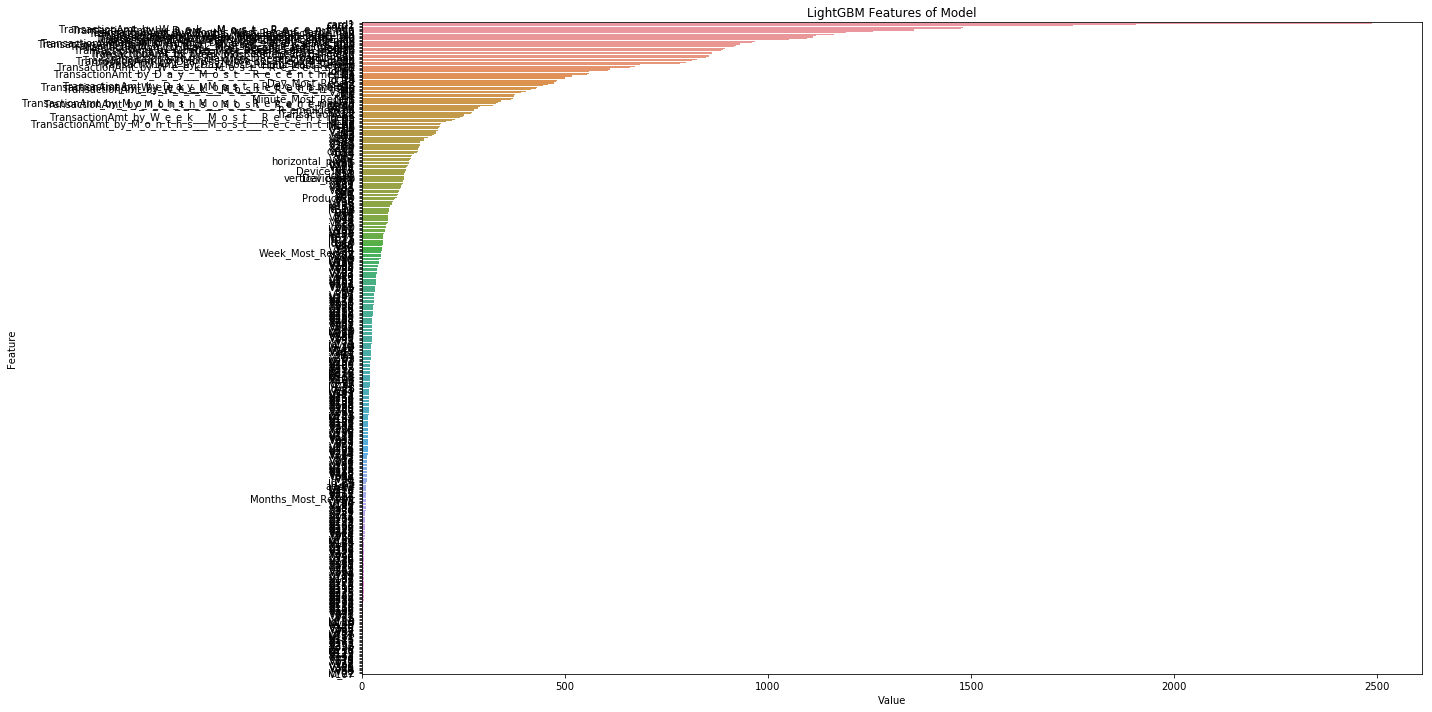

<Figure size 432x288 with 0 Axes>

In [38]:
submit = mb.run_model(data[0], data[1], data[2], 5, metric_func = roc_auc_score, get_probab = True, save_varimp = True, params = params, oversmp = True)

In [39]:
submit_pred= pd.DataFrame(submit[0])
submit_pred.columns = ['isFraud']
sub = pd.concat([df_test_txn['TransactionID'], submit_pred], axis = 1)

In [40]:
sub.to_csv('submission_model_fraud_lightgbm.csv', index = False)

In [41]:
!kaggle competitions submit -c ieee-fraud-detection -f submission_model_fraud_lightgbm.csv -m "Working submission my lightgbm, oversample with mistake"

100%|██████████████████████████████████████| 14.4M/14.4M [00:04<00:00, 3.77MB/s]
Successfully submitted to IEEE-CIS Fraud Detection